<a href="https://colab.research.google.com/github/fatimasood/XAI-Diabetes-Prediction/blob/main/XAI_for_Prediction_of_Diabetes_using_Stacking_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# ============================================================
#  INSTALL REQUIRED PACKAGES
# ============================================================
!pip install -q imbalanced-learn xgboost lime

# ============================================================
#  IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

from imblearn.combine import SMOTEENN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML

# ============================================================
#  RANDOM SEED
# ============================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================
#  LOAD PIMA DIABETES DATASET (Same dataset as paper)
# ============================================================
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = [
    "Pregnancies","Glucose","BloodPressure","SkinThickness",
    "Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"
]

df = pd.read_csv(url, names=columns)
print("Dataset shape:", df.shape)
df.head()

# ============================================================
#  CONVERT IMPOSSIBLE ZERO VALUES TO NaN (as per paper)
# ============================================================
cols_with_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in cols_with_missing:
    df[col] = df[col].replace(0, np.nan)

print("\nMissing values after cleaning:")
print(df.isna().sum())

# ============================================================
#  KNN IMPUTATION (Paper)
# ============================================================
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("\nAfter KNN Imputation missing values:", df_imputed.isna().sum().sum())

# ============================================================
#  ANOMALY DETECTION (One-Class SVM) (Paper)
# ============================================================
X_temp = df_imputed.drop("Outcome", axis=1)

ocsvm = OneClassSVM(kernel='rbf', nu=0.10, gamma=0.05)
ocsvm_pred = ocsvm.fit_predict(X_temp)

df_clean = df_imputed[ocsvm_pred == 1].reset_index(drop=True)
print("\nDataset shape after anomaly removal:", df_clean.shape)

# ============================================================
#  TRAIN-TEST SPLIT (Before balancing)
# ============================================================
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Keep original for LIME
X_train_orig = X_train.copy().reset_index(drop=True)
X_test_orig = X_test.copy().reset_index(drop=True)

# ============================================================
#  STANDARD SCALING
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
#  SMOTE + ENN (Hybrid balancing used in paper)
# ============================================================
smote_enn = SMOTEENN(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE+ENN class distribution:")
print(pd.Series(y_train_bal).value_counts())

# ============================================================
#  BUILD STACKING ENSEMBLE (Paper)
#     Base models: KNN, SVM, XGB
#     Meta model:  RandomForest
# ============================================================
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', probability=True)),
    ('xgb', XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        eval_metric='logloss', random_state=RANDOM_STATE
    ))
]

meta_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)

print("\nTraining Stacking Model...")
stack.fit(X_train_bal, y_train_bal)
print("Training Completed.")

# ============================================================
#  EVALUATION
# ============================================================
y_pred = stack.predict(X_test_scaled)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\n===== MODEL PERFORMANCE =====")
print("Accuracy :", round(acc,4))
print("Precision:", round(prec,4))
print("Recall   :", round(rec,4))
print("F1 Score :", round(f1,4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ============================================================
#  WRAPPER FOR LIME PREDICTIONS
# ============================================================
def model_predict_proba_raw(X_raw):
    if isinstance(X_raw, pd.DataFrame):
        Xr = X_raw.values
    else:
        Xr = np.array(X_raw)
    Xr_scaled = scaler.transform(Xr)
    return stack.predict_proba(Xr_scaled)

# ============================================================
#  LIME EXPLAINER INITIALIZATION (Paper uses LIME)
# ============================================================
feature_names = X.columns.tolist()
class_names   = ["No Diabetes", "Diabetes"]

explainer = LimeTabularExplainer(
    training_data = X_train_orig.values,
    feature_names = feature_names,
    class_names = class_names,
    discretize_continuous=True,
    mode="classification",
    random_state=RANDOM_STATE
)

# ============================================================
#  LIME EXPLANATION FUNCTION
# ============================================================
def explain_instance(idx):
    print(f"\n======= LIME EXPLANATION FOR TEST ROW {idx} =======")

    instance_raw = X_test_orig.iloc[idx:idx+1]
    probs = model_predict_proba_raw(instance_raw)
    pred_class = int(np.argmax(probs))  # force Python int

    print(f"Predicted: {class_names[pred_class]} (Prob: {probs[0][pred_class]:.4f})")
    print("Feature Values:")
    display(instance_raw)

    # Generate explanation
    exp = explainer.explain_instance(
        data_row=instance_raw.values[0],
        predict_fn=lambda x: model_predict_proba_raw(
            pd.DataFrame(x, columns=feature_names)
        ),
        num_features=8
    )

    # ---- FIX: Identify correct label key available in LIME ----
    available_labels = list(exp.local_exp.keys())  # e.g. [1]

    if pred_class in available_labels:
        label_to_use = pred_class
    elif 1 in available_labels:       # binary fallback (diabetes class)
        label_to_use = 1
    else:
        label_to_use = available_labels[0]  # last fallback

    print("\nTop Contributing Features:")
    for f, val in exp.as_list(label=label_to_use):
        print(f"{f} --> {round(val,4)}")

    # Show HTML (always works)
    html = exp.as_html()
    display(HTML(html))

# ============================================================
#  GENERATE LIME EXPLANATIONS FOR THREE TEST INSTANCES
# ============================================================
example_indices = [2, 14, 19]   # Similar to paper's 3rd, 15th, 20th examples

for idx in example_indices:
    if idx < len(X_test_orig):
        explain_instance(idx)


Dataset shape: (768, 9)

Missing values after cleaning:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

After KNN Imputation missing values: 0

Dataset shape after anomaly removal: (420, 9)

Train/Test shapes: (336, 8) (84, 8)

After SMOTE+ENN class distribution:
Outcome
1.0    154
0.0    128
Name: count, dtype: int64

Training Stacking Model...
Training Completed.

===== MODEL PERFORMANCE =====
Accuracy : 0.6786
Precision: 0.5278
Recall   : 0.6552
F1 Score : 0.5846

Confusion Matrix:
[[38 17]
 [10 19]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.7917    0.6909    0.7379        55
         1.0     0.5278    0.6552    0.5846        29

    accuracy                         0.6786      

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
2         10.0    122.0           68.0           30.8    189.6  31.2   

   DiabetesPedigreeFunction   Age  
2                     0.258  41.0


Top Contributing Features:
Age > 40.00 --> 0.3298
28.80 < SkinThickness <= 35.00 --> 0.1207
Pregnancies > 6.00 --> 0.1174
131.90 < Insulin <= 192.00 --> 0.0904
117.00 < Glucose <= 140.50 --> 0.0399
27.00 < BMI <= 32.40 --> -0.014
0.24 < DiabetesPedigreeFunction <= 0.34 --> 0.0071
64.00 < BloodPressure <= 72.00 --> -0.0038



======= LIME EXPLANATION FOR TEST ROW 14 =======
Predicted: No Diabetes (Prob: 1.0000)
Feature Values:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
14          2.0    108.0           62.0           10.0    278.0  25.3   

    DiabetesPedigreeFunction   Age  
14                     0.881  22.0


Top Contributing Features:
SkinThickness <= 22.00 --> -0.3032
Age <= 24.00 --> -0.2207
97.00 < Glucose <= 117.00 --> -0.1905
BMI <= 27.00 --> -0.1585
Insulin > 192.00 --> 0.1248
BloodPressure <= 64.00 --> 0.0716
DiabetesPedigreeFunction > 0.58 --> 0.0505
1.00 < Pregnancies <= 3.00 --> -0.0344



======= LIME EXPLANATION FOR TEST ROW 19 =======
Predicted: No Diabetes (Prob: 1.0000)
Feature Values:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
19          3.0     82.0           70.0           17.4     51.4  21.1   

    DiabetesPedigreeFunction   Age  
19                     0.389  25.0


Top Contributing Features:
Glucose <= 97.00 --> -0.3046
SkinThickness <= 22.00 --> -0.2723
Insulin <= 80.70 --> -0.18
24.00 < Age <= 28.00 --> -0.1505
BMI <= 27.00 --> -0.1299
1.00 < Pregnancies <= 3.00 --> -0.0319
0.34 < DiabetesPedigreeFunction <= 0.58 --> 0.0128
64.00 < BloodPressure <= 72.00 --> 0.0084


Raw dataset shape: (768, 9)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1


Missing counts after cleaning:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Missing values after KNN impute: 0

Dataset shape after anomaly removal: (420, 9)
Class counts after OCSVM:
 Outcome
0.0    276
1.0    144
Name: count, dtype: int64

Train shape: (336, 8) Test shape: (84, 8)

After SMOTE+ENN (train only) class counts:
Outcome
1.0    154
0.0    128
Name: count, dtype: int64
Saved CSV: diabetes_preprocessed.csv
Saved Excel: diabetes_preprocessed.xlsx

Training stacking classifier...
Training done.

=== Performance on TEST ===
Accuracy:  0.6905
Precision: 0.5405
Recall:    0.6897
F1 Score:  0.6061

Confusion matrix:
 [[38 17]
 [ 9 20]]

Classification report:
               precision    recall  f1-score   support

         0.0 

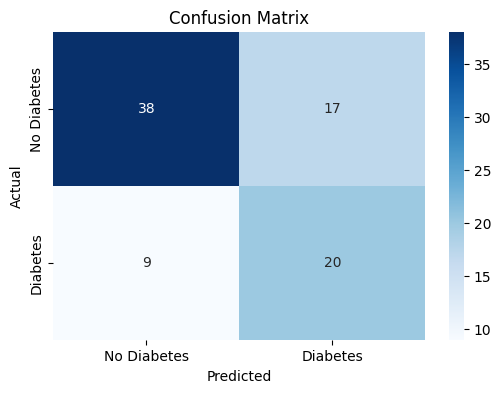

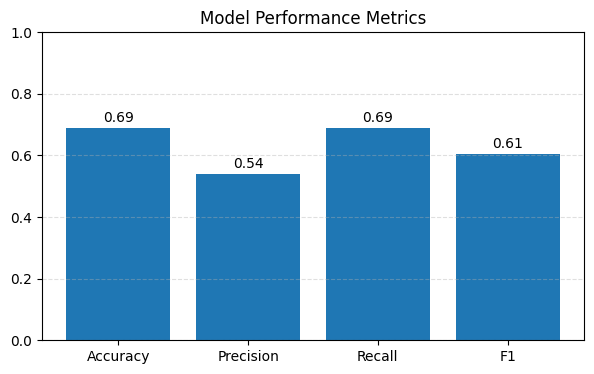

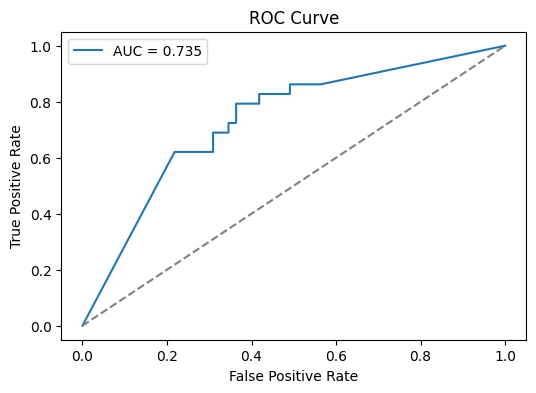

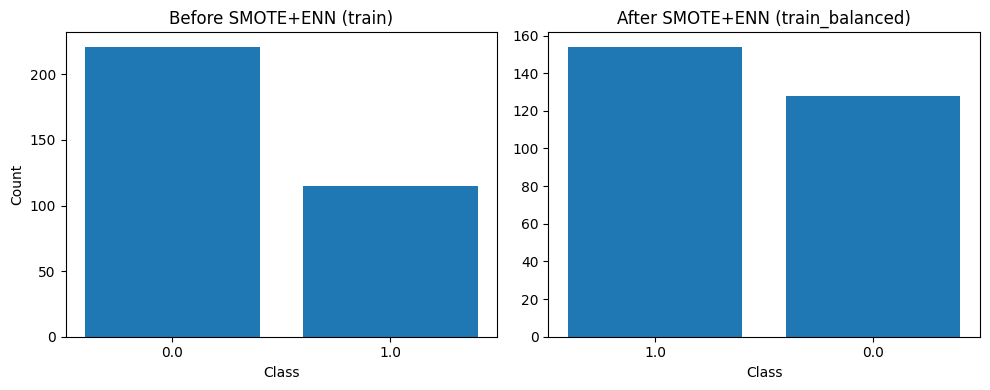

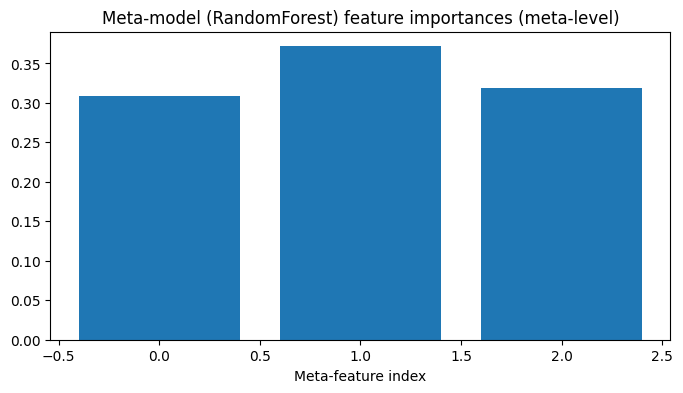

ExactExplainer explainer: 85it [00:44,  1.52it/s]


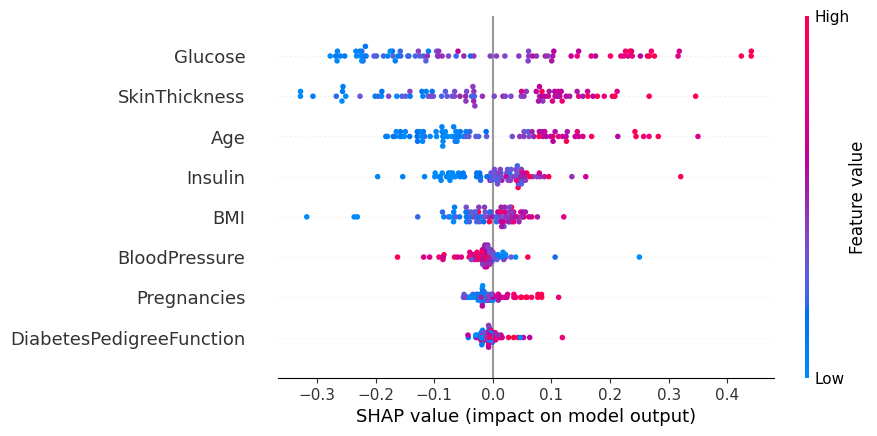

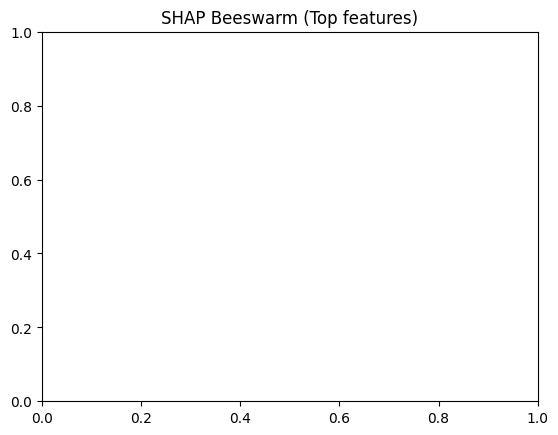

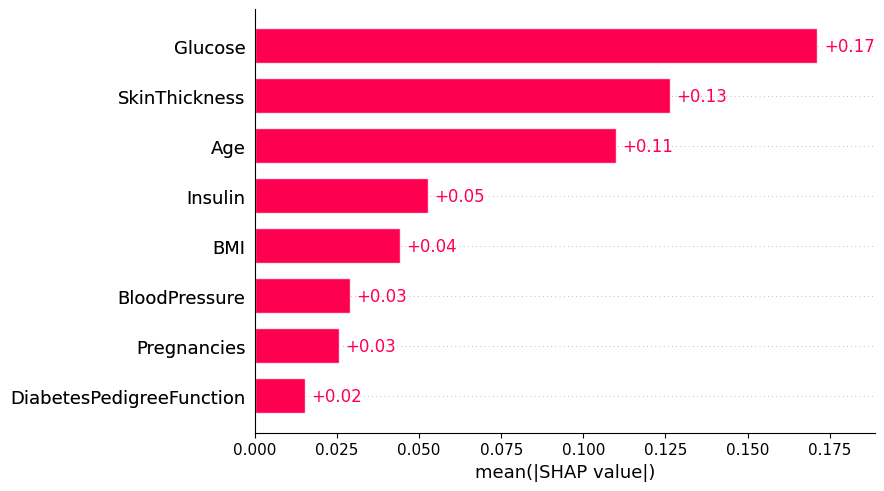

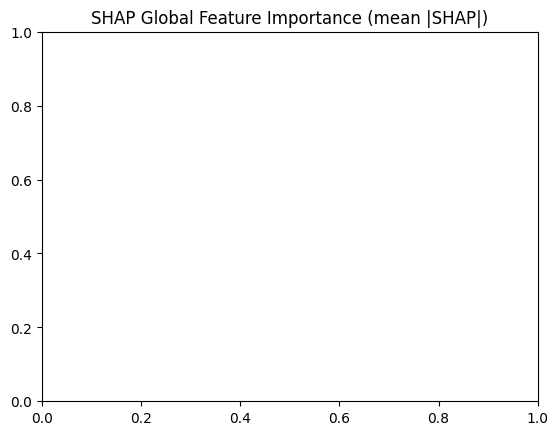

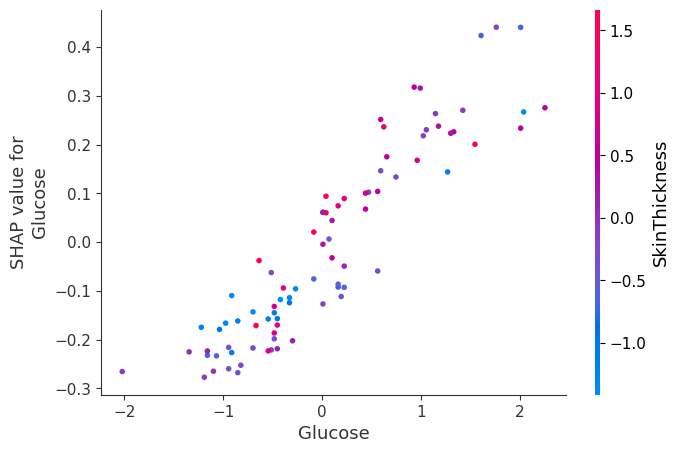


--- Local SHAP for test row 2 ---
Predicted probability of Diabetes: 1.0000   Actual: 0.0


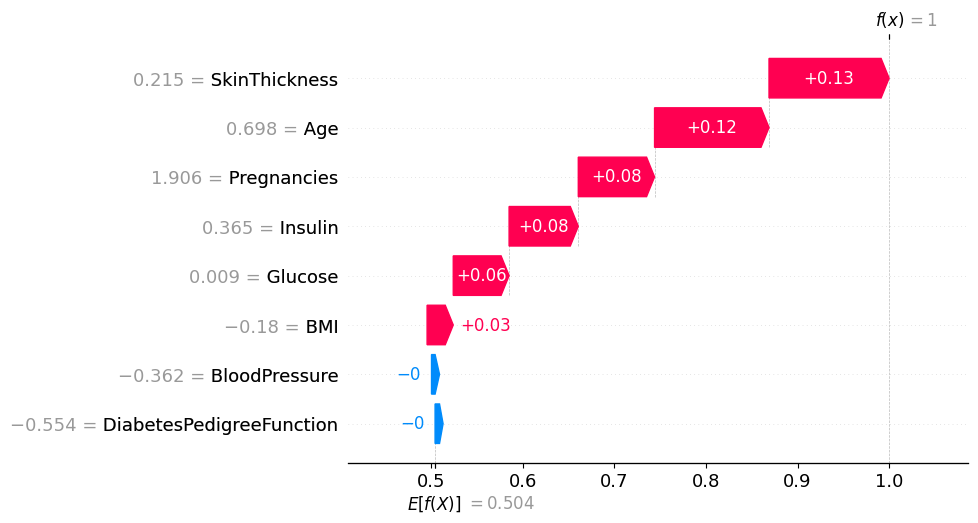

None


Raw (unscaled) feature values for this test row:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
2         10.0    122.0           68.0           30.8    189.6  31.2   

   DiabetesPedigreeFunction   Age  
2                     0.258  41.0


--- Local SHAP for test row 14 ---
Predicted probability of Diabetes: 0.0000   Actual: 0.0


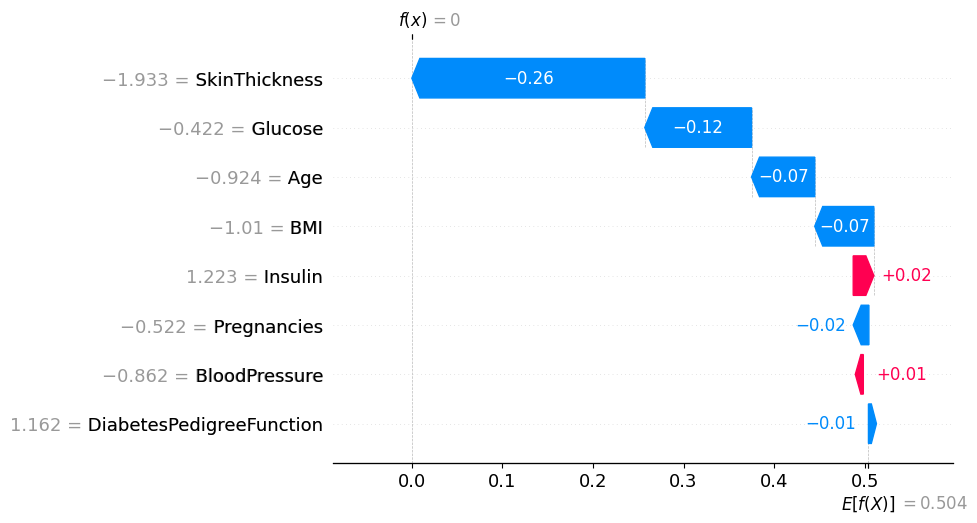

None


Raw (unscaled) feature values for this test row:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
14          2.0    108.0           62.0           10.0    278.0  25.3   

    DiabetesPedigreeFunction   Age  
14                     0.881  22.0


--- Local SHAP for test row 19 ---
Predicted probability of Diabetes: 0.0000   Actual: 0.0


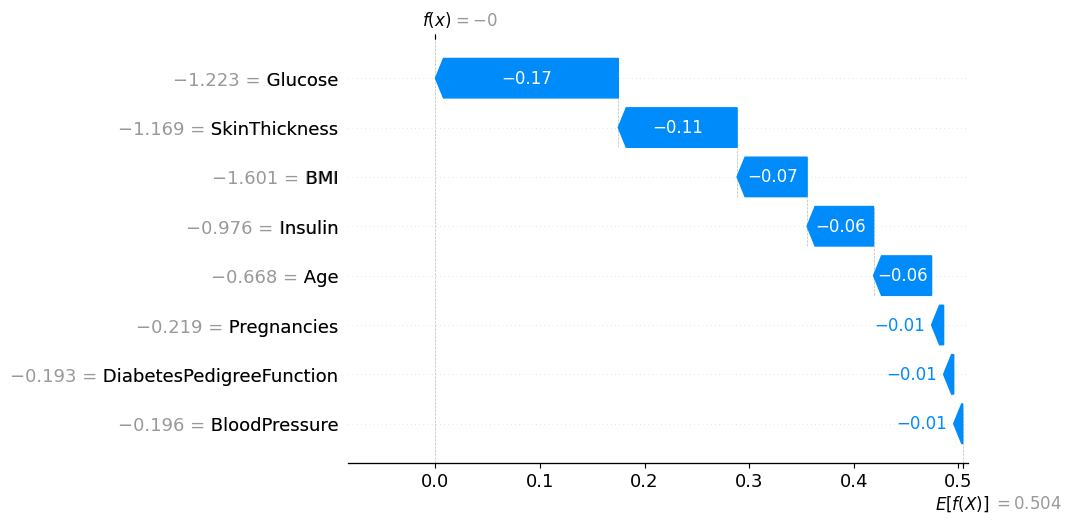

None


Raw (unscaled) feature values for this test row:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
19          3.0     82.0           70.0           17.4     51.4  21.1   

    DiabetesPedigreeFunction   Age  
19                     0.389  25.0

Saved confusion_matrix.png
Saved shap_global_bar.png

Notebook completed — visuals and SHAP explanations created.


<Figure size 640x480 with 0 Axes>

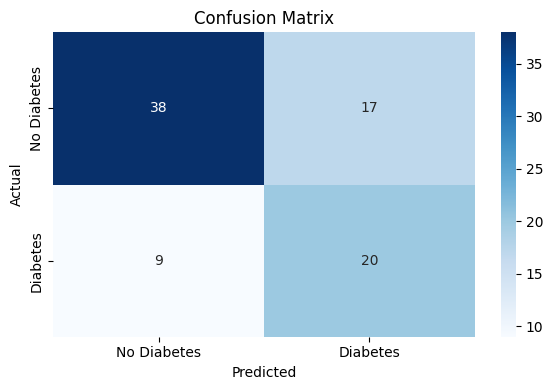

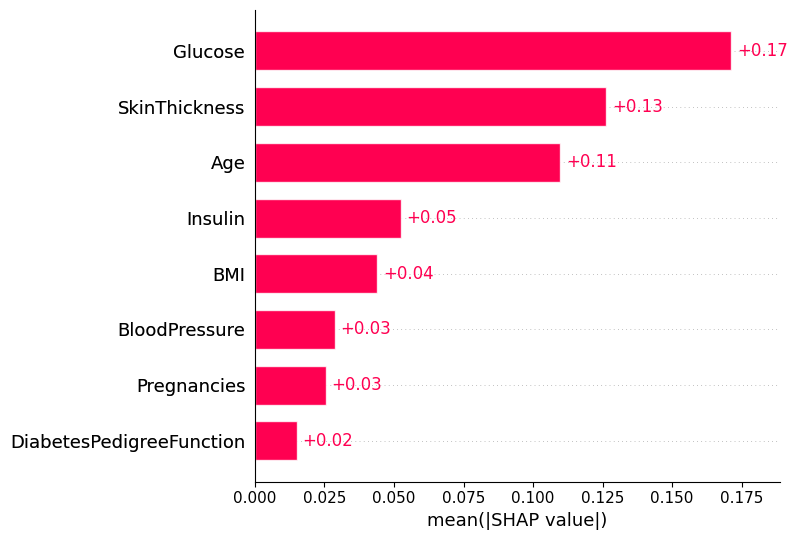

In [7]:
# ===========================
#  Install required packages
# ===========================
!pip install -q imbalanced-learn xgboost shap

# ===========================
#  Imports & settings
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

from imblearn.combine import SMOTEENN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ===========================
#  1) Load Dataset
# ===========================
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
df = pd.read_csv(url, names=cols)
print("Raw dataset shape:", df.shape)
display(df.head())

# ===========================
#  2) Replace impossible zeros with NaN (medical)
# ===========================
cols_with_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in cols_with_missing:
    df[c] = df[c].replace(0, np.nan)

print("\nMissing counts after cleaning:")
print(df.isna().sum())

# ===========================
#  3) KNN Imputation
# ===========================
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print("\nMissing values after KNN impute:", df_imputed.isna().sum().sum())

# ===========================
#  4) Anomaly detection — One-Class SVM
# ===========================
X_temp = df_imputed.drop("Outcome", axis=1).values
ocsvm = OneClassSVM(kernel='rbf', nu=0.10, gamma=0.05)
ocsvm_pred = ocsvm.fit_predict(X_temp)   # 1 = inlier, -1 = outlier
df_clean = df_imputed[ocsvm_pred == 1].reset_index(drop=True)
print("\nDataset shape after anomaly removal:", df_clean.shape)
print("Class counts after OCSVM:\n", df_clean["Outcome"].value_counts())

# ===========================
#  5) Train/test split BEFORE balancing (no leakage)
# ===========================
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# Keep copies of original unscaled test for display use
X_train_orig = X_train.copy().reset_index(drop=True)
X_test_orig = X_test.copy().reset_index(drop=True)

# ===========================
#  6) Scale BEFORE SMOTE (SMOTE works better on scaled features)
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ===========================
#  7) SMOTE + ENN on TRAIN only
# ===========================
smote_enn = SMOTEENN(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE+ENN (train only) class counts:")
print(pd.Series(y_train_bal).value_counts())

# Preprocessed dataset after KNN imputation + OCSVM outlier removal
df_preprocessed = df_clean.copy()  # df_clean is after anomaly removal

# Save as CSV
df_preprocessed.to_csv("diabetes_preprocessed.csv", index=False)
print("Saved CSV: diabetes_preprocessed.csv")

# Save as Excel
df_preprocessed.to_excel("diabetes_preprocessed.xlsx", index=False)
print("Saved Excel: diabetes_preprocessed.xlsx")


# ===========================
#  8) Build stacking ensemble (KNN, SVM, XGB -> RF meta)
# ===========================
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
]
meta_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

stack = StackingClassifier(estimators=base_learners, final_estimator=meta_model, passthrough=False, n_jobs=-1)

print("\nTraining stacking classifier...")
stack.fit(X_train_bal, y_train_bal)
print("Training done.")

# ===========================
#  9) Evaluate on TEST set
# ===========================
y_pred = stack.predict(X_test_scaled)
y_proba = stack.predict_proba(X_test_scaled)[:,1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\n=== Performance on TEST ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# ===========================
#  10) Visualizations — Confusion matrix, metrics bar, ROC, class distribution
# ===========================
# Confusion matrix (heatmap)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes','Diabetes'],
            yticklabels=['No Diabetes','Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Metrics bar
metrics_names = ["Accuracy","Precision","Recall","F1"]
values = [acc, prec, rec, f1]
plt.figure(figsize=(7,4))
bars = plt.bar(metrics_names, values)
plt.ylim(0,1)
plt.title("Model Performance Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.4)
for b,v in zip(bars, values):
    plt.text(b.get_x()+b.get_width()/2, v+0.02, f"{v:.2f}", ha='center')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Class distribution: before vs after SMOTE+ENN (train)
orig_counts = y_train.value_counts()
balanced_counts = pd.Series(y_train_bal).value_counts()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(orig_counts.index.astype(str), orig_counts.values)
plt.title("Before SMOTE+ENN (train)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.subplot(1,2,2)
plt.bar(balanced_counts.index.astype(str), balanced_counts.values)
plt.title("After SMOTE+ENN (train_balanced)")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

# Meta-model feature importances (if meaningful)
try:
    meta = stack.final_estimator_
    if hasattr(meta, "feature_importances_"):
        imp = meta.feature_importances_
        # Note: for stacking without passthrough, meta-level features correspond to base learner outputs (harder to map to raw features)
        plt.figure(figsize=(8,4))
        plt.bar(range(len(imp)), imp)
        plt.title("Meta-model (RandomForest) feature importances (meta-level)")
        plt.xlabel("Meta-feature index")
        plt.show()
except Exception:
    pass

# ===========================
#  11) SHAP explainability (global + local)
# ===========================
# We will create a SHAP explainer that uses a representative background sample.
# Use scaled data (the model expects scaled input).
feature_names = X.columns.tolist()

# Build background dataset from balanced training data (small sample to speed up)
# X_train_bal is scaled numpy array; convert to DataFrame for SHAP plotting with feature names
background = shap.sample(pd.DataFrame(X_train_bal, columns=feature_names), nsamples=100, random_state=RANDOM_STATE)

# SHAP explainer: use model predict_proba; explainer will auto-select best algorithm
# We wrap the model so it returns probability for class 1
def model_proba_for_shap(X_input):
    # X_input is numpy array or DataFrame scaled as the model expects
    # ensure shape / dtype
    return stack.predict_proba(np.array(X_input))[:,1]

explainer = shap.Explainer(model_proba_for_shap, masker=background, feature_names=feature_names)

# Compute SHAP values for a subset of test set (avoid huge compute)
X_test_df_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)
shap_vals = explainer(X_test_df_scaled)   # this returns a ShapleyValues object

# Global summary (beeswarm)
plt.figure(figsize=(8,6))
shap.plots.beeswarm(shap_vals, max_display=10)
plt.title("SHAP Beeswarm (Top features)")
plt.show()

# Global bar plot (mean absolute)
plt.figure(figsize=(8,6))
shap.plots.bar(shap_vals, max_display=10)
plt.title("SHAP Global Feature Importance (mean |SHAP|)")
plt.show()

# Dependence plot for Glucose (or pick one feature)
if "Glucose" in feature_names:
    shap.dependence_plot("Glucose", shap_vals.values, X_test_df_scaled, feature_names=feature_names)

# ===========================
#  12) Local explanations — waterfall & force for specific test rows
# ===========================
# Choose some test indices to explain (same as earlier: 2, 14, 19 if exist)
example_indices = [2, 14, 19]
shap.initjs()

for idx in example_indices:
    if idx < len(X_test_df_scaled):
        print(f"\n--- Local SHAP for test row {idx} ---")
        row = X_test_df_scaled.iloc[idx:idx+1]
        pred_prob = model_proba_for_shap(row.values)[0]
        print(f"Predicted probability of Diabetes: {pred_prob:.4f}   Actual: {y_test.reset_index(drop=True).iloc[idx]}")
        # Waterfall (nice single-instance breakdown)
        display(shap.plots.waterfall(shap_vals[idx], max_display=10))
        # Force plot (interactive)
        # Note: force plot in notebook may show interactive HTML
        display(shap.plots.force(shap_vals[idx]))
        # Also print raw feature values (unscaled) for reference
        print("\nRaw (unscaled) feature values for this test row:")
        display(X_test_orig.iloc[idx:idx+1])

# ===========================
#  13) Save key figures as PNG (optional)
# ===========================
plt.figure()  # blank to avoid overlap
# Example: save confusion matrix earlier: replot quickly and save
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes','Diabetes'],
            yticklabels=['No Diabetes','Diabetes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=200)
print("Saved confusion_matrix.png")

# Save SHAP bar plot
plt.figure(figsize=(8,6))
shap.plots.bar(shap_vals, max_display=10, show=False)
plt.tight_layout()
plt.savefig("shap_global_bar.png", dpi=200)
print("Saved shap_global_bar.png")

print("\nNotebook completed — visuals and SHAP explanations created.")
